In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [126]:
states = [
    "jakarta", "bandung", "surabaya", "makassar", "samarinda", "bali" 
]
N = len(states)
edges = [
    ("jakarta", "bandung", 108.98), 
    ("jakarta", "surabaya", 649.7 ), 
    ("jakarta", "makassar", 1384.37), 
    ("jakarta", "samarinda", 1296.42), 
    ("bandung", "surabaya", 567.62), 
    ("bandung", "makassar", 1321.25), 
    ("bandung", "samarinda", 1276.98), 
    ("bandung", "bali", 833.46), 
    ("surabaya", "bali", 285.62), 
    ("makassar", "bali", 614.46),
    ("samarinda", "bali", 920.67),
    ("surabaya", "makassar", 774.51),
    ("surabaya", "samarinda", 895.01),
    ("makassar", "samarinda", 573.80)
]
edges_distances = np.array(list(map(lambda x: x[2], edges))).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(10, 90))
edges_distances = scaler.fit_transform(edges_distances)
edges_distances.reshape(1, -1)[0]
scaled_edges = []
for i in range(len(edges)):
    scaled_edges.append(
        (edges[i][0], edges[i][1], round(edges_distances.reshape(1, -1)[0][i], 2))
    )
edges = scaled_edges

In [127]:
start = "jakarta"
goal = "bali"

In [128]:
G = nx.Graph()
G.add_edges_from(list(map(lambda x: (x[0], x[1]), edges)))

In [129]:
position = nx.spring_layout(G, seed=42)

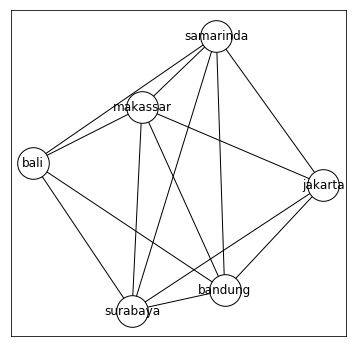

In [130]:
plt.figure(figsize=(6, 6))
nx.draw_networkx_nodes(G, position, node_size=1000, node_color="w", edgecolors="k")
nx.draw_networkx_edges(G, position)
nx.draw_networkx_labels(G, position)
plt.show()

In [162]:
R = pd.DataFrame(-np.ones((N, N)), index=states, columns=states)
R

,jakarta,bandung,surabaya,makassar,samarinda,bali
jakarta,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
bandung,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
surabaya,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
makassar,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
samarinda,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
bali,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [163]:
for a, b,c in edges:
    R.loc[a, b] = 100 if b == goal else 100 - c
    R.loc[b, a] = 100 if a == goal else 100 - c
R.loc[goal, goal] = 100
R

,jakarta,bandung,surabaya,makassar,samarinda,bali
jakarta,-1.00,90.00,56.08,10.00,15.52,-1.0
bandung,90.00,-1.00,61.23,13.96,16.74,100.0
surabaya,56.08,61.23,-1.00,48.25,40.70,100.0
makassar,10.00,13.96,48.25,-1.00,60.84,100.0
samarinda,15.52,16.74,40.70,60.84,-1.00,100.0
bali,-1.00,44.56,78.92,58.29,39.09,100.0


In [164]:
Q = pd.DataFrame(np.zeros((N, N)), index=states, columns=states)
Q

,jakarta,bandung,surabaya,makassar,samarinda,bali
jakarta,0.0,0.0,0.0,0.0,0.0,0.0
bandung,0.0,0.0,0.0,0.0,0.0,0.0
surabaya,0.0,0.0,0.0,0.0,0.0,0.0
makassar,0.0,0.0,0.0,0.0,0.0,0.0
samarinda,0.0,0.0,0.0,0.0,0.0,0.0
bali,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
temp = R[start]

In [200]:
temp[temp >= 0].index

Index(['bandung', 'surabaya', 'makassar', 'samarinda'], dtype='object')

In [201]:
def step(state):
    """
    R = Reward table
    r = action reward
    """
    r = R[state]
    available_actions = r[r >= 0].index
    return np.random.choice(available_actions)

In [202]:
def update(state, action, gamma=0.8):
    """
    Q = Q-table
    q = action quality
    """
    q = Q[state]
    maxq = q.max()
    
    #kasus untuk maxq lebih dari 1
    mask = (q == maxq)
    if mask.sum() > 1:
        maxq = np.random.choice(q[mask])
    Q.loc[state, action] = R.loc[state, action] + (gamma * maxq)

In [203]:
state = start

In [204]:
action = step(state)
action

'surabaya'

In [205]:
update(state, action)

In [206]:
Q = pd.DataFrame(np.zeros((N, N)), index=states, columns=states)

In [211]:
for _ in range(3000):
    state = np.random.choice(states)
    while state == start:
        state = np.random.choice(states)
    thisset = {start}
    action = step(state)
    update(state, action, gamma=0.9)

In [212]:
Q

,jakarta,bandung,surabaya,makassar,samarinda,bali
jakarta,0.000,0.000,0.000,0.000,0.000,0.000
bandung,940.104,0.000,911.334,864.064,866.844,950.104
surabaya,937.108,942.258,0.000,929.278,921.728,981.028
makassar,872.461,876.421,910.711,0.000,923.301,962.461
samarinda,860.701,861.921,885.881,906.021,0.000,945.181
bali,0.000,944.560,978.920,958.290,939.090,1000.000


In [213]:
Q/Q.values.max()

,jakarta,bandung,surabaya,makassar,samarinda,bali
jakarta,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
bandung,0.940104,0.000000,0.911334,0.864064,0.866844,0.950104
surabaya,0.937108,0.942258,0.000000,0.929278,0.921728,0.981028
makassar,0.872461,0.876421,0.910711,0.000000,0.923301,0.962461
samarinda,0.860701,0.861921,0.885881,0.906021,0.000000,0.945181
bali,0.000000,0.944560,0.978920,0.958290,0.939090,1.000000


In [214]:
step = [start]
while step[-1] != goal:
    q = Q[step[-1]]
    mask = (q == q.max())
    if mask.sum() > 1:
        step.append(np.random.choice(q[mask].index))
    else:
        step.append(q.idxmax())
print(step)

['jakarta', 'bandung', 'bali']
